In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import RectBivariateSpline
import astroscrappy
import pandas as pd

from cartopy import config
import cartopy.crs as ccrs

from PIL import Image

Data file from: 
     
     -Battalio, J. M., & Wang, H. (2019). The Mars Dust Activity Database (MDAD) [Data set]. Harvard Dataverse. https://doi.org/10.7910/DVN/F8R2JX

In [27]:
mars_data = pd.read_csv('MDAD.csv')
mars_data.tail()

,Mars Year,Mission subphase,Sol,Ls,Centroid longitude,Centroid latitude,Area (square km),Member ID,Sequence ID,Maximum latitude,Minimum latitude,Confidence interval,Missing data
0,29,B01,1,120.9,28.85,76.95000,90356.984,B01_001,NaN,83.25,71.35,75,no
1,29,B01,2,121.4,29.65,74.25000,156925.090,B01_001,NaN,81.95,66.85,50,no
2,29,B01,2,121.4,-117.05,-7.64999,35037.652,B01_004,NaN,-5.45,-9.95,100,no
3,29,B01,3,121.8,36.05,71.75000,209257.090,B01_001,NaN,77.45,64.75,50,no
4,29,B01,3,121.8,-146.55,77.65000,186898.530,B01_006,NaN,84.25,70.05,50,no


In [4]:
mars_data.describe()

,Mars Year,Sol,Ls,Centroid longitude,Centroid latitude,Area (square km),Maximum latitude,Minimum latitude,Confidence interval
count,14974.000000,14974.000000,14974.000000,14974.000000,14974.000000,1.497400e+04,14974.000000,14974.000000,14974.000000
mean,28.485375,15.943369,169.819328,-6.565073,-4.481294,9.760592e+05,3.062909,-11.978943,69.245025
std,2.361254,9.014203,98.180863,97.940152,47.558879,2.117939e+06,48.713605,46.402684,14.861928
min,24.000000,1.000000,0.000000,-179.950000,-82.250000,1.343662e+03,-78.550000,-89.950000,50.000000
25%,27.000000,8.000000,88.200000,-78.450000,-47.150000,1.029449e+05,-41.900000,-53.387500,50.000000
50%,29.000000,16.000000,171.100000,-24.550000,-22.900000,3.056906e+05,-10.350000,-31.800000,75.000000
75%,30.000000,23.000000,227.542500,71.750000,46.050000,9.227905e+05,55.100000,36.100000,75.000000
max,32.000000,37.000000,359.720000,179.950000,82.250000,4.126140e+07,89.950000,77.150000,100.000000


## Map of Mars that we will use

<img src='./images/Map of Mars.png' width = 500>

> Source: Astropedia "Mars MGS MOLA DEM 463m v2" with significant contributions from: Smith et al., 2001, Albee et al., 2001, Neumann et al., 2001; Neumann, Smith & Zuber, 2003, Lemoine et al., 2001, Neumann, 2002, GeoScience Node, NASA JPL, 2010,
Obtained from: https://astrogeology.usgs.gov/search/details/Mars/GlobalSurveyor/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m/cub



## Possible Investigations:
**Must do!**

1) Storm Duration/Area (maybe comparison to Earth?):
    -How long does a typical Martian dust storm last?
    -What is the average size of a Martian dust storm?
        _How might the Martian atmosphere (or anything else Martian) contribute to these things?_

**Optional (but will probably be necessary if the above is too easy):**

2) Path/location of the storm vs. Topography (need outside data):
    
    -Are there certain locations in Mars where dust storms tend to occur?
        
        Does Martian topography/elevation have an effect on location?
        
3) Path/location of storm vs. wind direction/speed (need outside data[which I don't know if they even record that kind of data...]):
    
    -Do the path of the storms observed correspond to the wind that exists on Mars, if so, does it have a certain preferred direction or speed?  What could this signify, if a pattern is identified.


## Possible approaches to:
 *Take the csv data, create new dataframe columns to clarify anything if needed. 
 
 *Keep in mind that the timescale in the data is relative to Mars, Martian year/day(sol), so we will probably need a conversion factor and a new column.
 
 *Note: Storms can last for many Martian days...  Each storm has a unique 'Member ID.'  Identical Member ID's on different days mean that the same storm persisted/was present/was detected on those days.
 
1) Keeping in mind the note above, we can keep track of storm duration by sorting member IDs and use bar/box and whisker plots to help determine statistics (average, median, mode, outliers) for storm duration by looking at how many sols the storm last.  In addition to that, to find the average area/span of the dust storm, we can once again do the same thing, but using the 'Area (square km)' column with member ID sorting.

Optional

2) and 3) I will need to use the map of Mars and import it into a globular shape like PlateCarree, I can then use the Centriod longitude and latitude columns to plot a scatter plot of either unique storms one at a time, or all at a time.  Based on the results of 1), I can determine if I need to separate the main data set into two types of categories (one-day storms and multiple-day storms) and determine if the null hypothesis that one-day storms and multiple-day storms do not have a correlation with wind direction, or speed.

# Part 1 - Mapping Dust Storms to the Surface of Mars

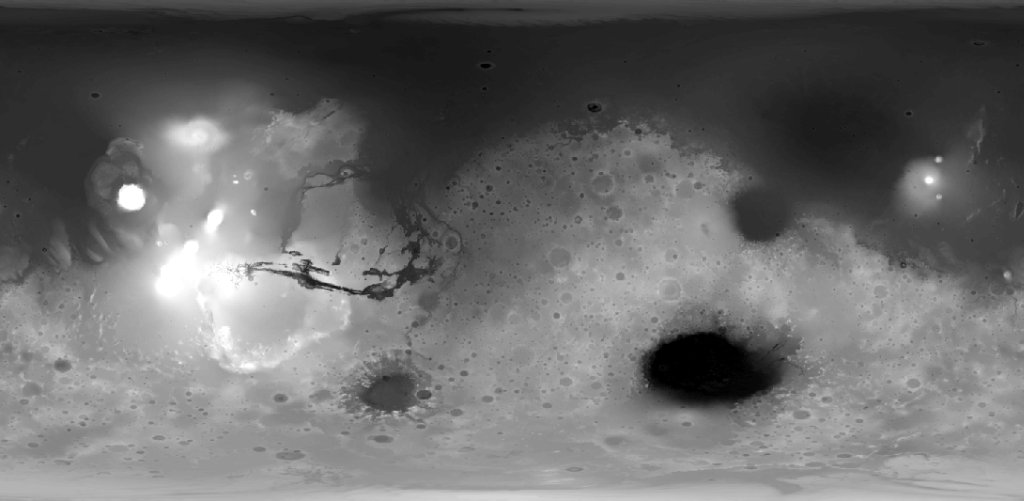

In [156]:
mars_img = Image.open('./images/Map of Mars.png')
mars_img


The image above shows a picture of the shaded surface of Mars. I know that Olympus Mons is the discernable white circular area, resembling its shield-like structure.  The white areas are areas of high elevation since there is a set of volcanoes/mountains to the southeast of Olympus Mon.  Past that mountain range is Valles Marineris, so the darker shaded areas are areas of low elevation, as Valles Marineris is a sort of rift on the surface of Mars.  

With more researching, we can identify that the top of the image is the northern hemisphere, and the bottom of the image is the southern hemisphere.  We can also confirm that darker shades indicate lower elevation since the Hellas basin is known to be caused by a crater impact on the southern hemisphere.  The lighter areas are confirmed to be areas of higher elevation.

(1024, 501)

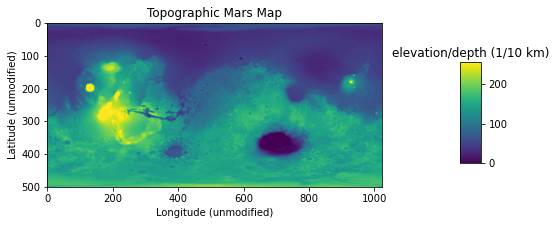

In [161]:
plt.imshow(mars_img)
plt.title('Topographic Mars Map')
plt.xlabel('Longitude (unmodified)')
plt.ylabel('Latitude (unmodified)')

color_ax = plt.axes([1.08, 0.3, 0.05, 0.35])
plt.colorbar(cax=color_ax)
plt.title('elevation/depth (1/10 km)');

mars_img.size

Figure 1

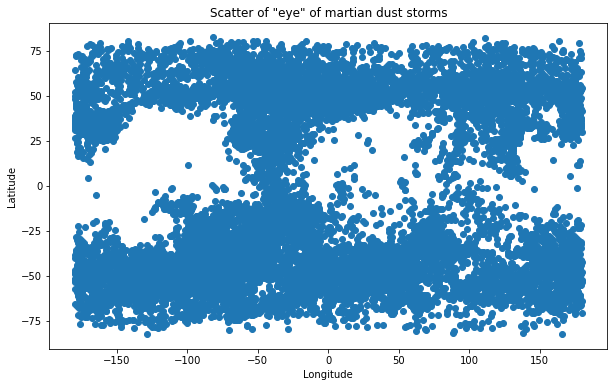

In [163]:
plt.figure(figsize=(10,6))
plt.scatter(mars_data['Centroid longitude'], mars_data['Centroid latitude'])
plt.title('Scatter of "eye" of martian dust storms')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Figure 2

In [17]:
fix_mars = lambda x,y:(mars_img.size[0]*x/np.max(xticks),\
                mars_img.size[1]*(np.max(yticks)-y)/np.max(yticks)) #Purpose: Reshape the image, so that the latitude and longitudes are reasonable!

#mars_img.size[0]*x/
#mars_img.size[1]*(np.max(yticks)-y)/

In [18]:
mars_img.size[0]
mars_img.size[1]

501

In [19]:
xticks = np.linspace(0,400,9)
yticks = np.linspace(0,200,9)
xtickspy, ytickspy = fix_mars(xticks,yticks)

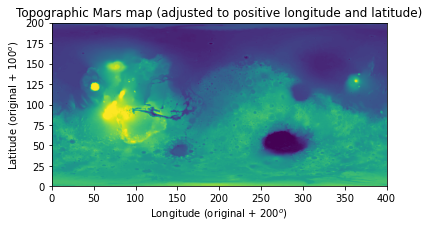

In [165]:
fig,ax=plt.subplots()
ax.imshow(mars_img)
plt.title('Topographic Mars map (adjusted to positive longitude and latitude)')
plt.xlabel('Longitude (original + 200$^o$)')
plt.ylabel('Latitude (original + 100$^o$)') #I'm not sure of how to allow negative numbers in, so I just shifted the latitude and longitude by adding the positive latitudes and longitudes respectively

ax.set_xticks(xtickspy)
ax.set_yticks(ytickspy)
ax.set_xticklabels(xticks.astype('int'))
ax.set_yticklabels(yticks.astype('int'))



plt.show()

Figure 3

With the figure above, the equator is located at 100$^o$ latitude and the prime meridian is at 200$^o$

In [180]:
#Need to make new centroid locations to fit the graph above!

mars_data['Adjusted Centroid longitude'] = (mars_data['Centroid longitude'] + 185) * (11/4)
mars_data['Adjusted Centroid latitude'] = (mars_data['Centroid latitude'] + 90) * (11/4)
mars_data.describe()

,Mars Year,Sol,Ls,Centroid longitude,Centroid latitude,Area (square km),Maximum latitude,Minimum latitude,Confidence interval,Adjusted Centroid longitude,Adjusted Centroid latitude
count,14974.000000,14974.000000,14974.000000,14974.000000,14974.000000,1.497400e+04,14974.000000,14974.000000,14974.000000,14974.000000,14974.000000
mean,28.485375,15.943369,169.819328,-6.565073,-4.481294,9.760592e+05,3.062909,-11.978943,69.245025,490.696051,235.176441
std,2.361254,9.014203,98.180863,97.940152,47.558879,2.117939e+06,48.713605,46.402684,14.861928,269.335418,130.786919
min,24.000000,1.000000,0.000000,-179.950000,-82.250000,1.343662e+03,-78.550000,-89.950000,50.000000,13.887500,21.312500
25%,27.000000,8.000000,88.200000,-78.450000,-47.150000,1.029449e+05,-41.900000,-53.387500,50.000000,293.012500,117.837500
50%,29.000000,16.000000,171.100000,-24.550000,-22.900000,3.056906e+05,-10.350000,-31.800000,75.000000,441.237500,184.525000
75%,30.000000,23.000000,227.542500,71.750000,46.050000,9.227905e+05,55.100000,36.100000,75.000000,706.062500,374.137500
max,32.000000,37.000000,359.720000,179.950000,82.250000,4.126140e+07,89.950000,77.150000,100.000000,1003.612500,473.687500


In [48]:
mars_data.size

224610

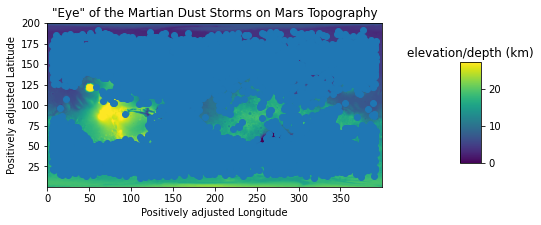

In [196]:
fig,ax=plt.subplots()
ax.imshow(mars_img)

ax.set_xticks(xtickspy)
ax.set_yticks(ytickspy)
ax.set_xticklabels(xticks.astype('int'))
ax.set_yticklabels(yticks.astype('int'))
ax.set_title('"Eye" of the Martian Dust Storms on Mars Topography')
ax.set_xlabel('Positively adjusted Longitude')
ax.set_ylabel('Positively adjusted Latitude')

plt.scatter(mars_data['Adjusted Centroid longitude'], mars_data['Adjusted Centroid latitude']) #For some reason the initial adjustment was not enough, so the scatter points are scaled by 8/3 

color_ax = plt.axes([1.08, 0.3, 0.05, 0.35])
plt.colorbar(cax=color_ax)
plt.clim(0,27) #Adjust so that is shows ~27 km difference between top of Olympus Mons to the Hellas basin.
plt.title('elevation/depth (km)');

plt.show()

Figure 4

# Part 2 - Focus on Storm Duration

In [2]:
import seaborn as sns

In [9]:
mars_data.columns

Index(['Mars Year', 'Mission subphase', 'Sol', 'Ls', 'Centroid longitude',
       'Centroid latitude', 'Area (square km)', 'Member ID', 'Sequence ID',
       'Maximum latitude', 'Minimum latitude', 'Confidence interval',
       'Missing data'],
      dtype='object')

In [101]:
mars_dataB01 = mars_data[mars_data['Mission subphase']=='B01'] #Focus on Mission subphase B01 to get a feel of the data

mars_dataB01.head()
mars_dataB01.size

429

In [102]:
len(pd.unique(mars_dataB01['Member ID'])) #Keep narrowing down to Member ID to determine that there were 17 storms tracked in this sub-mission.

17

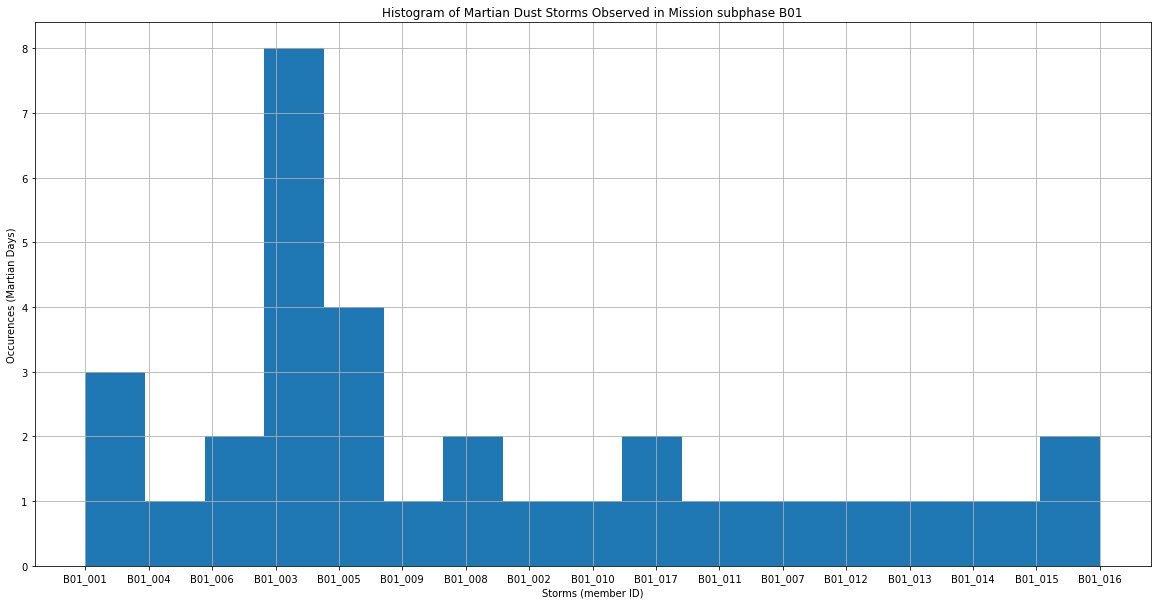

In [103]:
plt.figure(figsize=(20,10)) #This histogram shows that the amount of occurences of a certain storm in the data (see conclusion for more detail)
plt.hist(mars_dataB01['Member ID'], bins=17)
plt.xlabel('Storms (member ID)')
plt.ylabel('Occurences (Martian Days)')
plt.title('Histogram of Martian Dust Storms Observed in Mission subphase B01')
plt.grid()
plt.show()

Figure 5

In [100]:
mars_dataB01[mars_dataB01['Member ID']=='B01_003'] #check that the histogram is accurate. It is!!

,Mars Year,Mission subphase,Sol,Ls,Centroid longitude,Centroid latitude,Area (square km),Member ID,Sequence ID,Maximum latitude,Minimum latitude,Confidence interval,Missing data
6,29,B01,4,122.3,-60.15,71.65,46494.668,B01_003,NaN,74.65,68.15,100,no
7,29,B01,5,122.7,-49.35,70.85,877364.000,B01_003,NaN,82.75,55.15,50,no
9,29,B01,6,123.1,-50.55,68.95,1388181.600,B01_003,NaN,83.75,53.25,50,no
11,29,B01,7,123.6,-47.15,67.15,1267101.500,B01_003,NaN,81.25,44.55,50,no
13,29,B01,8,124.0,-55.15,70.85,979544.440,B01_003,NaN,81.25,58.65,50,no
15,29,B01,9,124.5,-49.05,66.25,1139548.900,B01_003,NaN,79.85,53.25,50,no
16,29,B01,10,125.0,-42.85,64.15,617903.000,B01_003,NaN,72.55,54.35,50,no
17,29,B01,11,125.4,-36.55,64.55,646943.690,B01_003,NaN,75.05,52.65,50,no


In [104]:
mars_datay24 = mars_data[mars_data['Mars Year']<25]
mars_datay24.tail()
mars_datay24.size

13858

In [96]:
mars_datay24['Member ID'].unique()
len(pd.unique(mars_datay24['Member ID'])) #There are 652 storms tracked during this Mars-year (24)

652

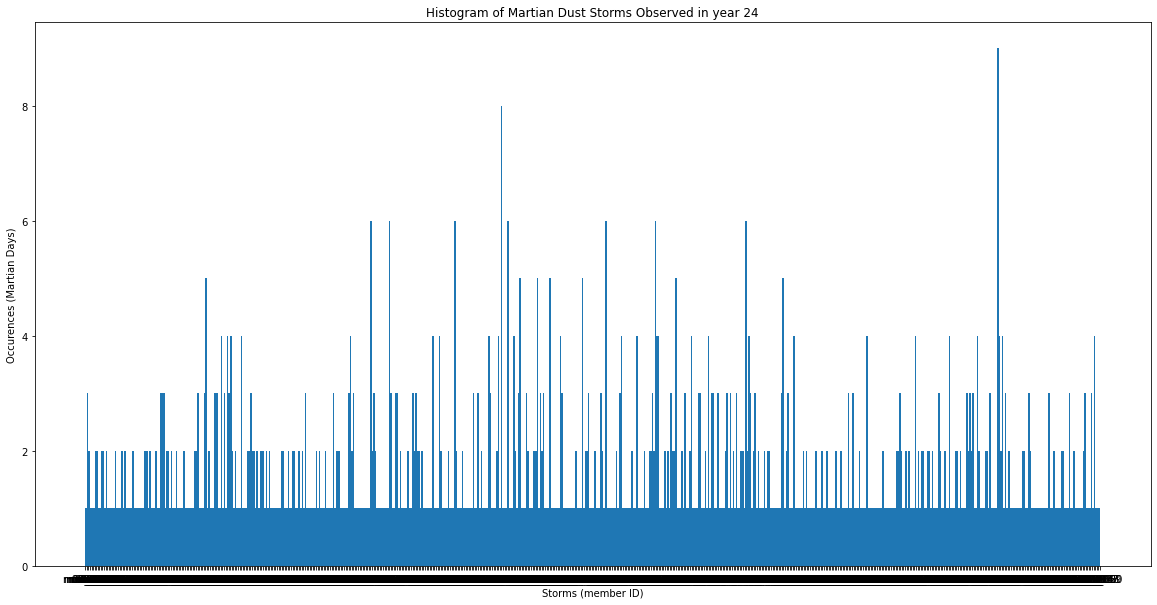

In [99]:
plt.figure(figsize=(20,10))  #show the number of occurences of each storm in Mars-year 24
plt.hist(mars_datay24['Member ID'], bins=652) #bin = 652 so that there is one bin for one storm
plt.xlabel('Storms (member ID)')
plt.ylabel('Occurences (Martian Days)')
plt.title('Histogram of Martian Dust Storms Observed in year 24')

plt.show()

Figure 6

# Part 3 - Focus on Storm Size

In [107]:
mars_data['Area (square km)'].head() #Shifting the focus to area of the storm

0     90356.984
1    156925.090
2     35037.652
3    209257.090
4    186898.530
Name: Area (square km), dtype: float64

In [108]:
mars_data['Area (square km)'].size

14974

In [120]:
storm_areay24 = mars_data[mars_data['Mars Year'].isin([24])]
storm_areay32 = mars_data[mars_data['Mars Year'].isin([32])]
storm_areay24.head()

,Mars Year,Mission subphase,Sol,Ls,Centroid longitude,Centroid latitude,Area (square km),Member ID,Sequence ID,Maximum latitude,Minimum latitude,Confidence interval,Missing data
10789,24,m02,1,150.23,-93.75,-50.3,2388263.20,m02_001,NaN,-38.2,-60.0,75,yes
10790,24,m02,1,150.23,-151.35,-42.1,1362738.90,m02_002,NaN,-29.5,-52.7,75,no
10791,24,m02,1,150.23,50.35,-41.7,437124.03,m02_004,NaN,-33.2,-49.8,75,no
10792,24,m02,1,150.23,21.05,-51.5,1151823.10,m02_005,NaN,-41.7,-59.1,50,no
10793,24,m02,1,150.23,131.35,-45.8,264336.75,m02_009,NaN,-41.3,-50.6,75,no


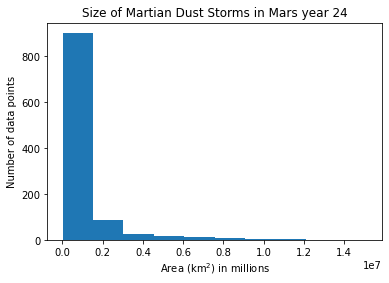

In [130]:
plt.hist(storm_areay24['Area (square km)']) #Looking at the size at Mars-year 24
plt.title('Size of Martian Dust Storms in Mars year 24')
plt.xlabel('Area (km$^2$) in millions')
plt.ylabel('Number of data points')
plt.show()

Figure 7

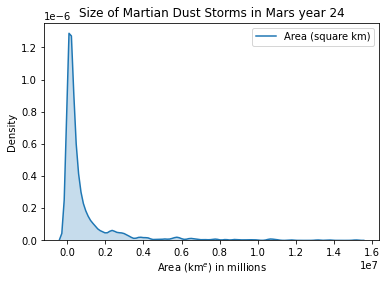

In [132]:
sns.kdeplot(storm_areay24['Area (square km)'], shade=True) #Plotting a density plot, no messy bins.
plt.title('Size of Martian Dust Storms in Mars year 24')
plt.xlabel('Area (km$^e$) in millions')
plt.ylabel('Density')
plt.show()

Figure 8

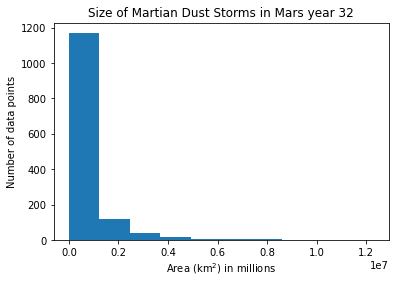

In [208]:
plt.hist(storm_areay32['Area (square km)']) #Looking at storm sizes for Mars-year 32
plt.title('Size of Martian Dust Storms in Mars year 32')
plt.xlabel('Area (km$^2$) in millions')
plt.ylabel('Number of data points')
plt.show()

Figure 9

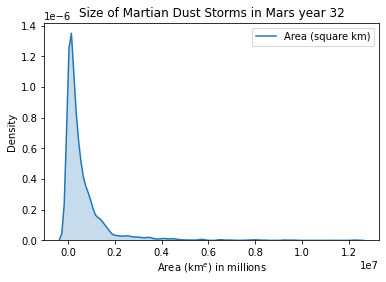

In [133]:
sns.kdeplot(storm_areay32['Area (square km)'], shade=True) #density plot for storms in Mars-year 32
plt.title('Size of Martian Dust Storms in Mars year 32')
plt.xlabel('Area (km$^e$) in millions')
plt.ylabel('Density')
plt.show()

Figure 10

In [126]:
storm_areay31 = mars_data[mars_data['Mars Year'].isin([31])]

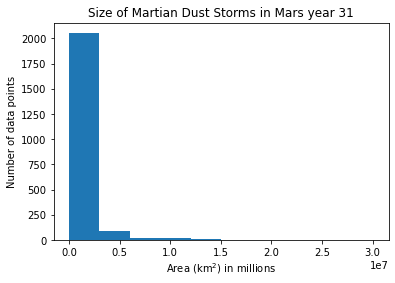

In [129]:
plt.hist(storm_areay31['Area (square km)']) #Need a third year for better comparison, so took Mars-year 31
plt.title('Size of Martian Dust Storms in Mars year 31')
plt.xlabel('Area (km$^2$) in millions')
plt.ylabel('Number of data points')
plt.show()

Figure 11

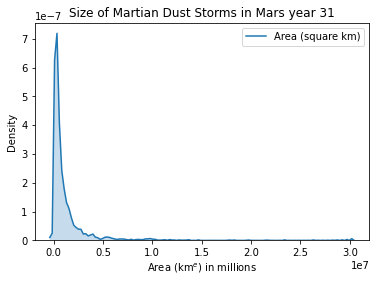

In [134]:
sns.kdeplot(storm_areay31['Area (square km)'], shade=True) #density plot for storms sizes in Mars-year 31
plt.title('Size of Martian Dust Storms in Mars year 31')
plt.xlabel('Area (km$^e$) in millions')
plt.ylabel('Density')
plt.show()

Figure 12

# Experimental

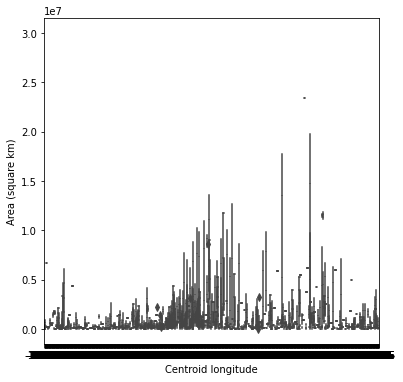

In [137]:
plt.figure(figsize=(6,6)) #This can show the sizes of the dust storm on each longitudes
sns.boxplot(x='Centroid longitude', y='Area (square km)', data=storm_areay31)
plt.title('Box and Whisker Longitude locator')
plt.show()

Figure 13

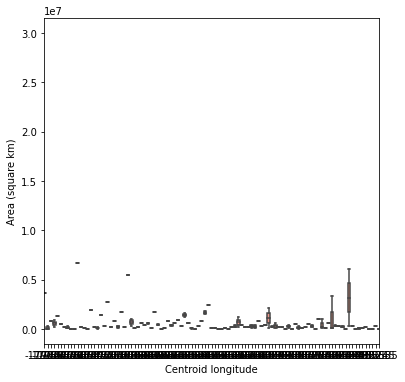

In [200]:
plt.figure(figsize=(6,6)) #zoomed in for more clarity
sns.boxplot(x='Centroid longitude', y='Area (square km)', data=storm_areay31)
plt.xlim(0,100)
plt.show()

Figure 14

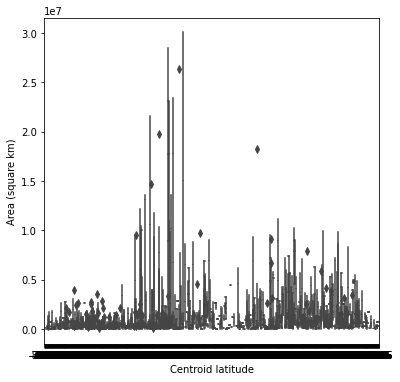

In [152]:
plt.figure(figsize=(6,6)) #shows area of the dust storm at each latitude
sns.boxplot(x='Centroid latitude', y='Area (square km)', data=storm_areay31)
plt.show()

Figure 15

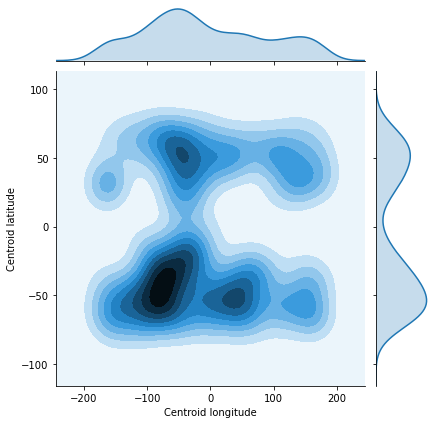

In [201]:
sns.jointplot(storm_areay31['Centroid longitude'], storm_areay31['Centroid latitude'], kind='kde')
plt.show() #Can be a substitude for the scatter plot of centroids

Figure 16

# Bootstrapping

In [127]:
MDS_size24 = np.mean(storm_areay24['Area (square km)'])
print(MDS_size24)

925251.8049770173


In [141]:
y24_mean_area = [] #Start with Mars-year 24

for n in range (0,20000):
    resampled = storm_areay24.sample(n=len(storm_areay24), replace = True)
    mean = np.mean(resampled['Area (square km)'])
    y24_mean_area.append(mean)

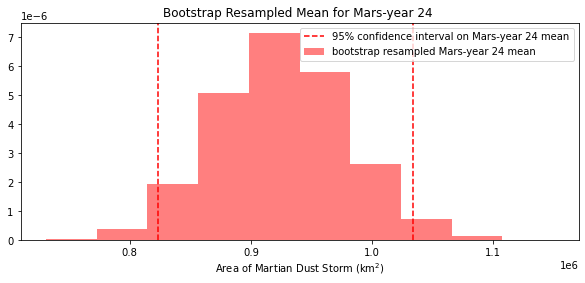

In [144]:
plt.figure(figsize=(10,4))
plt.hist(y24_mean_area, alpha=0.5, density=True, color='red', label='bootstrap resampled Mars-year 24 mean')
plt.axvline(x=np.percentile(y24_mean_area, 2.5), linestyle='--', color='red', label='95% confidence interval on Mars-year 24 mean')
plt.axvline(x=np.percentile(y24_mean_area, 97.5), linestyle='--', color='red')
plt.xlabel('Area of Martian Dust Storm (km$^2$)')
plt.title('Bootstrap Resampled Mean for Mars-year 24 ')
plt.legend()
plt.show()

Figure 17

In [145]:
y31_mean_area = [] #Resampling for Mars-year 31

for n in range (0,20000):
    resampled = storm_areay31.sample(n=len(storm_areay31), replace = True)
    mean = np.mean(resampled['Area (square km)'])
    y31_mean_area.append(mean)

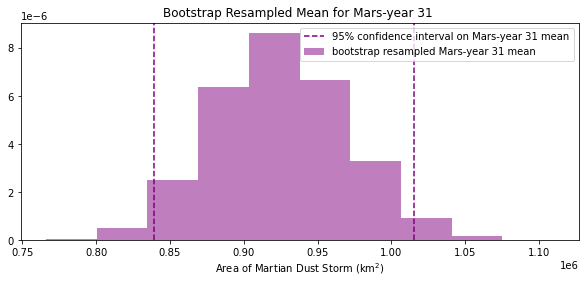

In [148]:
plt.figure(figsize=(10,4))
plt.hist(y31_mean_area, alpha=0.5, density=True, color='purple', label='bootstrap resampled Mars-year 31 mean')
plt.axvline(x=np.percentile(y31_mean_area, 2.5), linestyle='--', color='purple', label='95% confidence interval on Mars-year 31 mean')
plt.axvline(x=np.percentile(y31_mean_area, 97.5), linestyle='--', color='purple')
plt.xlabel('Area of Martian Dust Storm (km$^2$)')
plt.title('Bootstrap Resampled Mean for Mars-year 31 ')
plt.legend()
plt.show()

Figure 18

In [146]:
y32_mean_area = []  #resample for Mars-year 32

for n in range (0,20000):
    resampled = storm_areay32.sample(n=len(storm_areay32), replace = True)
    mean = np.mean(resampled['Area (square km)'])
    y32_mean_area.append(mean)

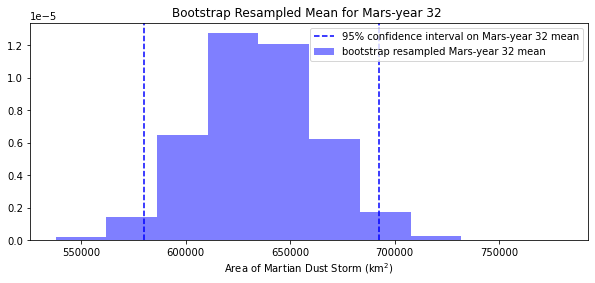

In [149]:
plt.figure(figsize=(10,4))
plt.hist(y32_mean_area, alpha=0.5, density=True, color='blue', label='bootstrap resampled Mars-year 32 mean')
plt.axvline(x=np.percentile(y32_mean_area, 2.5), linestyle='--', color='blue', label='95% confidence interval on Mars-year 32 mean')
plt.axvline(x=np.percentile(y32_mean_area, 97.5), linestyle='--', color='blue')
plt.xlabel('Area of Martian Dust Storm (km$^2$)')
plt.title('Bootstrap Resampled Mean for Mars-year 32 ')
plt.legend()
plt.show()

Figure 19

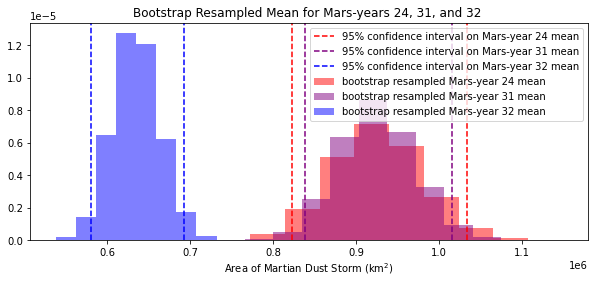

In [151]:
plt.figure(figsize=(10,4))
plt.hist(y24_mean_area, alpha=0.5, density=True, color='red', label='bootstrap resampled Mars-year 24 mean')
plt.axvline(x=np.percentile(y24_mean_area, 2.5), linestyle='--', color='red', label='95% confidence interval on Mars-year 24 mean')
plt.axvline(x=np.percentile(y24_mean_area, 97.5), linestyle='--', color='red')
plt.xlabel('Area of Martian Dust Storm (km$^2$)')
plt.title('Bootstrap Resampled Mean for Mars-year 24 ')


plt.hist(y31_mean_area, alpha=0.5, density=True, color='purple', label='bootstrap resampled Mars-year 31 mean')
plt.axvline(x=np.percentile(y31_mean_area, 2.5), linestyle='--', color='purple', label='95% confidence interval on Mars-year 31 mean')
plt.axvline(x=np.percentile(y31_mean_area, 97.5), linestyle='--', color='purple')
plt.xlabel('Area of Martian Dust Storm (km$^2$)')
plt.title('Bootstrap Resampled Mean for Mars-year 31 ')


plt.hist(y32_mean_area, alpha=0.5, density=True, color='blue', label='bootstrap resampled Mars-year 32 mean')
plt.axvline(x=np.percentile(y32_mean_area, 2.5), linestyle='--', color='blue', label='95% confidence interval on Mars-year 32 mean')
plt.axvline(x=np.percentile(y32_mean_area, 97.5), linestyle='--', color='blue')
plt.xlabel('Area of Martian Dust Storm (km$^2$)')
plt.title('Bootstrap Resampled Mean for Mars-years 24, 31, and 32 ')
plt.legend()
plt.show()

Figure 20

# Conclusion and Analysis
In Part 1, the goal was to map the dust storms onto the surface of Mars.  Although the first image shows up as shades of black and white, we are shown the topographic shading of the surface of Mars.  On the top left side of the image, we can see Olympus Mons in a light circular dot representing a topographic high, where as we see Valles Marineris (middle left) and Hellas Basin (bottom right) in a darker area representing a topographic low.  Next, the image is plotted to view the Martian topography in color with yellow representing high elevation while dark blue represents low elevation.  Paired with the scatter plot of the Martian dust storm centroids (storm "eye" or center point of the storm), we can see that the last figure in Part 1 (figure 4) shows that the center of the storms tend to exists in almost every part of Mars except in what looks to be high elevations.  With some further research, the yellow region that is nearly untouched by the "eye" of the dust storms is call the Tharsis Montes region, which is comprised of three volcanoes, so it support the topographic map that reveals a topographic high location on Mars.  It can be possible that this volcano/mountain range has the capability to block the Martian dust storm, which is similar to a rainshadow that is seen here on Earth, except that it now blocks dust.  With the "'Eye' of the Martian Dust Storms on Mars Topography" figure (figure 4), we can see that indeed, the storm centroids are not apparent in areas of mountain/volcanic ranges in general.  There does not seem to be a difference in where storms are located in the northern or southern hemispheres even though there is a noticeable difference in elevation between the two hemispheres.  Therefore, this suggests that centroids of the dust storms can be seen in any location on Mars and it does not discriminate based on elevation, rather only sharp changes in elevation will seem to deter the storm from existing or moving there.

This contradicts my prediction that dust storms would occur everywhere on Mars as there seems to be a lot of dust and I have heard of global dust storms.  However, this figure only shows the storm centroids so we do not have any information on the area of these storms based on these figures. 

In Part 2, I focused on the Martian dust storm duration.  In figure 5, the histogram shows the Member ID and the number of occurrences of that Member ID.  For simplicity purposes, I decided to focus on the Mission subphase B01, just to be able to get a feel of what data I will be working with.  It turns out that the data tracks certain storms by their Member ID, and each storm has its own unique Member ID.  In addition to that, no storm is repeated per Sol (Martian day), so by calculating the number of occurrences of a certain Member ID, I can determine how many Martian days a Martian dust storm exists on Mars.  Therefore, figure 5 shows that most of the storms that were tracked on Mission Subphase B01 lasted one Martian day.  However, the maximum duration of a Martian dust storm is 8 Martian days in this subphase (B01). 

Expanding to a bigger data set, I considered data only from the Mars-year 24 and plotted the number of occurrences for each unique storm (via Member ID) in a histogram.  The resulting figure 6 shows that majority of the storms lasted for one or two Martian days, but the maximum duration recorded was 9 Martian days.  In general, this is relatively the same range of duration as the dust storms that occur on Earth.

On Part 3, I focused on the size of the dust storm by taking three sets of data, one for a unique Mars-year (Mars-year 24, 31 at first, then Mars-year 32 for extra validation), to compare the dust storm sizes between different Mars-years.  Figures 7 and 9 show the histogram of the size of all the Martian dust storms that have occurred in Mars-year 24 and 31 respectively.  It shows a distribution that is left skewed which means that the size of the dust storm is in general smaller within 0.0 to 0.2 e$^7$ (0 to 2,000,000) km$^2$ in area.  Figure 11 was created later, focusing on Mars-year 32, to include more data sets for accuracy of the initial two data sets.  This histogram also showed a left skewed distribution which also suggests that the area of dust storms for Mars-year 32 is also similar in size to Mars-year 31 and 24.  I also created density plots for each of the Mars-years in order to have another view at the same data without worrying about bins of the histogram, and all of which shows left skewed distributions.

However, with some more analysis by bootstrap resampling and then plotting the histogram of all three resampled data sets (Mars-year 24, 31, and 32) in figure 20, we can see that although each individual histogram showed a left skewed distribution, the bootstrap resampled datasets indicate that the area for Martian dust storms are not always completely identical in size.  

# Acknowledgements, citations, and references:

-8.1 Bootstrap Resampling—Python Intro to Geoscience. (n.d.). Retrieved December 16, 2020, from https://maggieavery.github.io/PyEarth_EPS88_jupyterbook/folder_08/W8_bootstrapping.html

-Albee, A. L., Arvidson, R. E., Palluconi, F., & Thorpe, T. (2001). Overview of the Mars Global Surveyor mission. Journal of Geophysical Research: Planets, 106(E10), 23291–23316. https://doi.org/10.1029/2000JE001306

-Archinal, B. A., A’Hearn, M. F., Bowell, E., Conrad, A., Consolmagno, G. J., Courtin, R., Fukushima, T., Hestroffer, D., Hilton, J. L., Krasinsky, G. A., Neumann, G., Oberst, J., Seidelmann, P. K., Stooke, P., Tholen, D. J., Thomas, P. C., & Williams, I. P. (2011). Report of the IAU Working Group on Cartographic Coordinates and Rotational Elements: 2009. Celestial Mechanics and Dynamical Astronomy, 109(2), 101–135. https://doi.org/10.1007/s10569-010-9320-4

-Area distribution @ Countries of the World. (n.d.). Retrieved December 16, 2020, from http://www.studentsoftheworld.info/infopays/rank/area2.html

-Code Faster with Line-of-Code Completions, Cloudless Processing. (n.d.). Retrieved December 16, 2020, from https://www.kite.com

-de Vaucouleurs, G., Davies, M. E., & Sturms, F. M. (1973). Mariner 9 Areographic Coordinate System. Journal of Geophysical Research, 78(20), 4395–4404. https://doi.org/10.1029/JB078i020p04395

-Hille, K. (2015, September 18). The Fact and Fiction of Martian Dust Storms [Text]. NASA. http://www.nasa.gov/feature/goddard/the-fact-and-fiction-of-martian-dust-storms

-How do I select a subset of a DataFrame? —Pandas 1.1.5 documentation. (n.d.). Retrieved December 15, 2020, from https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/03_subset_data.html

-How to Count Distinct Values of a Pandas Dataframe Column? (2020, August 16). GeeksforGeeks. https://www.geeksforgeeks.org/how-to-count-distinct-values-of-a-pandas-dataframe-column/

-Lemoine, F. G., Smith, D. E., Rowlands, D. D., Zuber, M. T., Neumann, G. A., Chinn, D. S., & Pavlis, D. E. (2001). An improved solution of the gravity field of Mars (GMM-2B) from Mars Global Surveyor. Journal of Geophysical Research: Planets, 106(E10), 23359–23376. https://doi.org/10.1029/2000JE001426

-Mars Exploration: Multimedia. (n.d.). Retrieved December 16, 2020, from https://mars.nasa.gov/gallery/atlas/tharsis-montes.html

-mars.nasa.gov. (n.d.). Mars Facts | All About Mars. NASA’s Mars Exploration Program. Retrieved December 15, 2020, from https://mars.nasa.gov/all-about-mars/facts

-NASA - NASA Spacecraft Reveal Largest Crater in Solar System. (n.d.). [Feature]. Brian Dunbar. Retrieved December 15, 2020, from https://www.nasa.gov/mission_pages/MRO/news/mro-20080625.html

-NASA GISS: Science Briefs: Desert Dust, Dust Storms and Climate. (n.d.). Retrieved December 16, 2020, from https://www.giss.nasa.gov/research/briefs/miller_01/

-Neumann, G. A. (2003). Two Mars years of clouds detected by the Mars Orbiter Laser Altimeter. Journal of Geophysical Research, 108(E4), 5023. https://doi.org/10.1029/2002JE001849

-Neumann, G. A., Rowlands, D. D., Lemoine, F. G., Smith, D. E., & Zuber, M. T. (2001). Crossover analysis of Mars Orbiter Laser Altimeter data. Journal of Geophysical Research: Planets, 106(E10), 23753–23768. https://doi.org/10.1029/2000JE001381

-Questions About Mars Science. (n.d.). Retrieved December 15, 2020, from https://mars.nasa.gov/mgs/faqs/faq_sci.html

Seasons on Mars. (n.d.). Retrieved December 15, 2020, from https://www.msss.com/http/ps/seasons/seasons.html

-Smith, D. E. (1999). The Gravity Field of Mars: Results from Mars Global Surveyor. Science, 286(5437), 94–97. https://doi.org/10.1126/science.286.5437.94

-Smith, David E., Zuber, M. T., Frey, H. V., Garvin, J. B., Head, J. W., Muhleman, D. O., Pettengill, G. H., Phillips, R. J., Solomon, S. C., Zwally, H. J., Banerdt, W. B., Duxbury, T. C., Golombek, M. P., Lemoine, F. G., Neumann, G. A., Rowlands, D. D., Aharonson, O., Ford, P. G., Ivanov, A. B., … Sun, X. (2001). Mars Orbiter Laser Altimeter: Experiment summary after the first year of global mapping of Mars. Journal of Geophysical Research: Planets, 106(E10), 23689–23722. https://doi.org/10.1029/2000JE001364

-Wessel, P., & Smith, W. H. F. (1998). New, improved version of generic mapping tools released. Eos, Transactions American Geophysical Union, 79(47), 579–579. https://doi.org/10.1029/98EO00426
